## Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import CNN, build_resnet
from gaf import GAF
from train import train_model
import os
from pathlib import Path
from utils import ECGDataset, plot_classifier_curves, plot_gaf_samples,plot_gaf_both, evaluate_classifier
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

torch.manual_seed(42)
os.makedirs('./logs/',exist_ok=True)
os.makedirs('./saved_models',exist_ok=True)

# Model 1: CNN - GASF
log_path_1 = Path('./logs/cnn_gasf.csv')
model_path_1 = Path('./saved_models/cnn_gasf.pt')

# Model 2: CNN - GADF
log_path_2 = Path('./logs/cnn_gadf.csv')
model_path_2 = Path('./saved_models/cnn_gadf.pt')

# Model 3: CNN - GASF + GADF
log_path_3 = Path('./logs/cnn_both.csv')
model_path_3 = Path('./saved_models/cnn_both.pt')

# Model 4: ResNet - GASF + GADF
log_path_4 = Path('./logs/resnet_both.csv')
model_path_4 = Path('./saved_models/resnet_both.pt')

# Parameters
BATCH_SIZE=32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class_names = ['N','S','V','F','Q']

### Load Dataset

In [2]:
# Load datasets
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv', header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv', header=None)

# Extract features and labels
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].astype(int).values

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state=42)

# Load test set
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].astype(int).values
X_test,y_test = rus.fit_resample(X_test,y_test)

C:\Users\harsh\AppData\Local\Temp\ipykernel_15136\663069994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


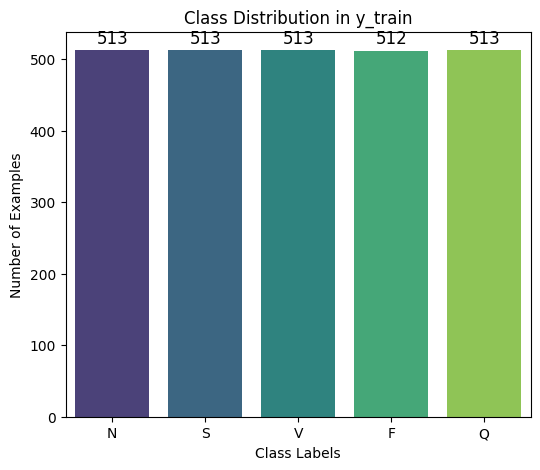

In [3]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

## Exploratory Data Analysis

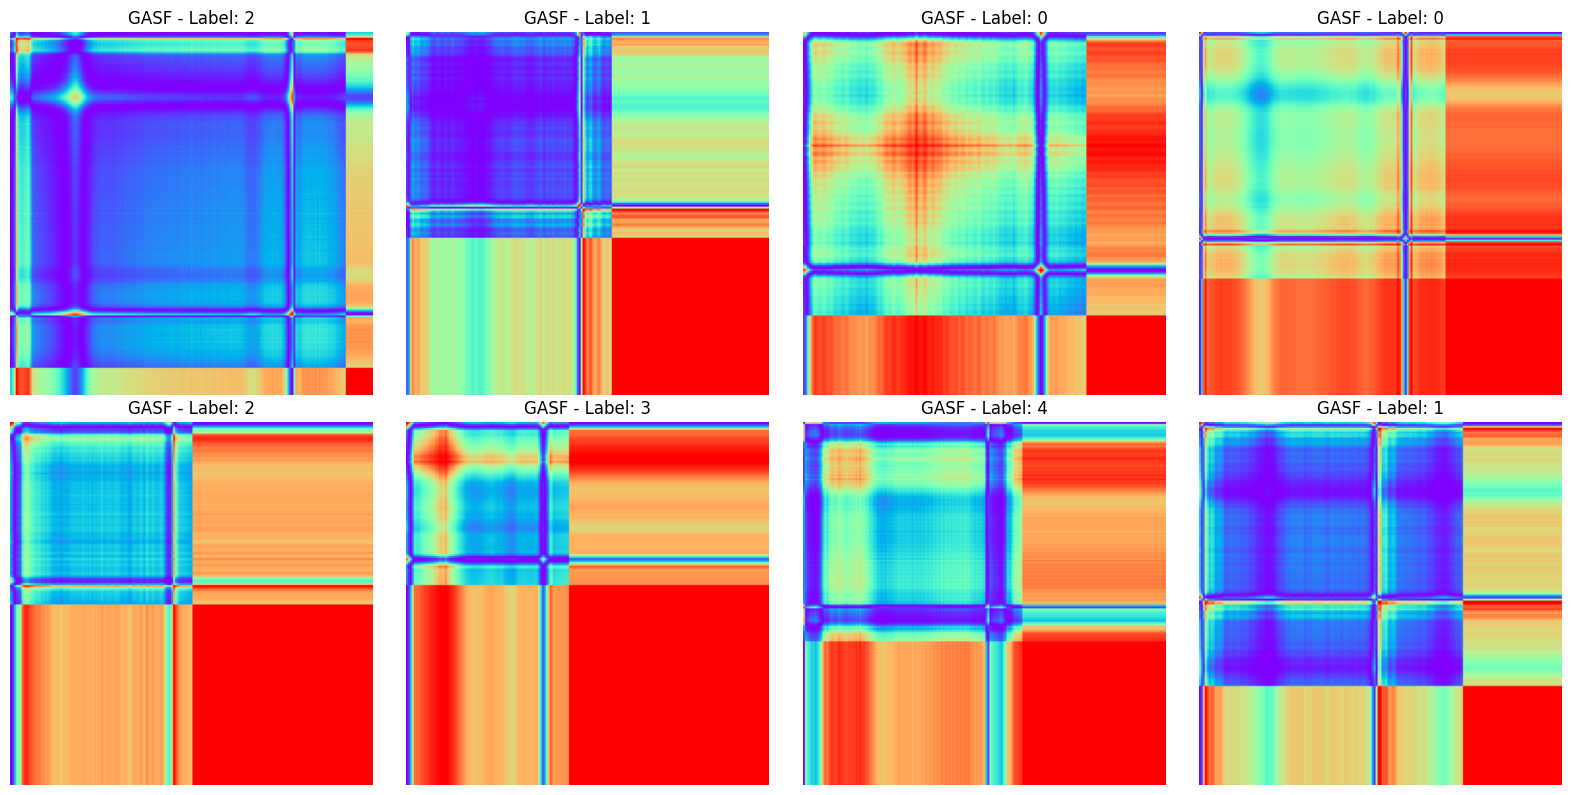

In [4]:
train_dataset_gasf = ECGDataset(X_train, y_train,gaf_mode='gasf')

plot_gaf_samples(dataset=train_dataset_gasf,num_samples=8,cols=4)


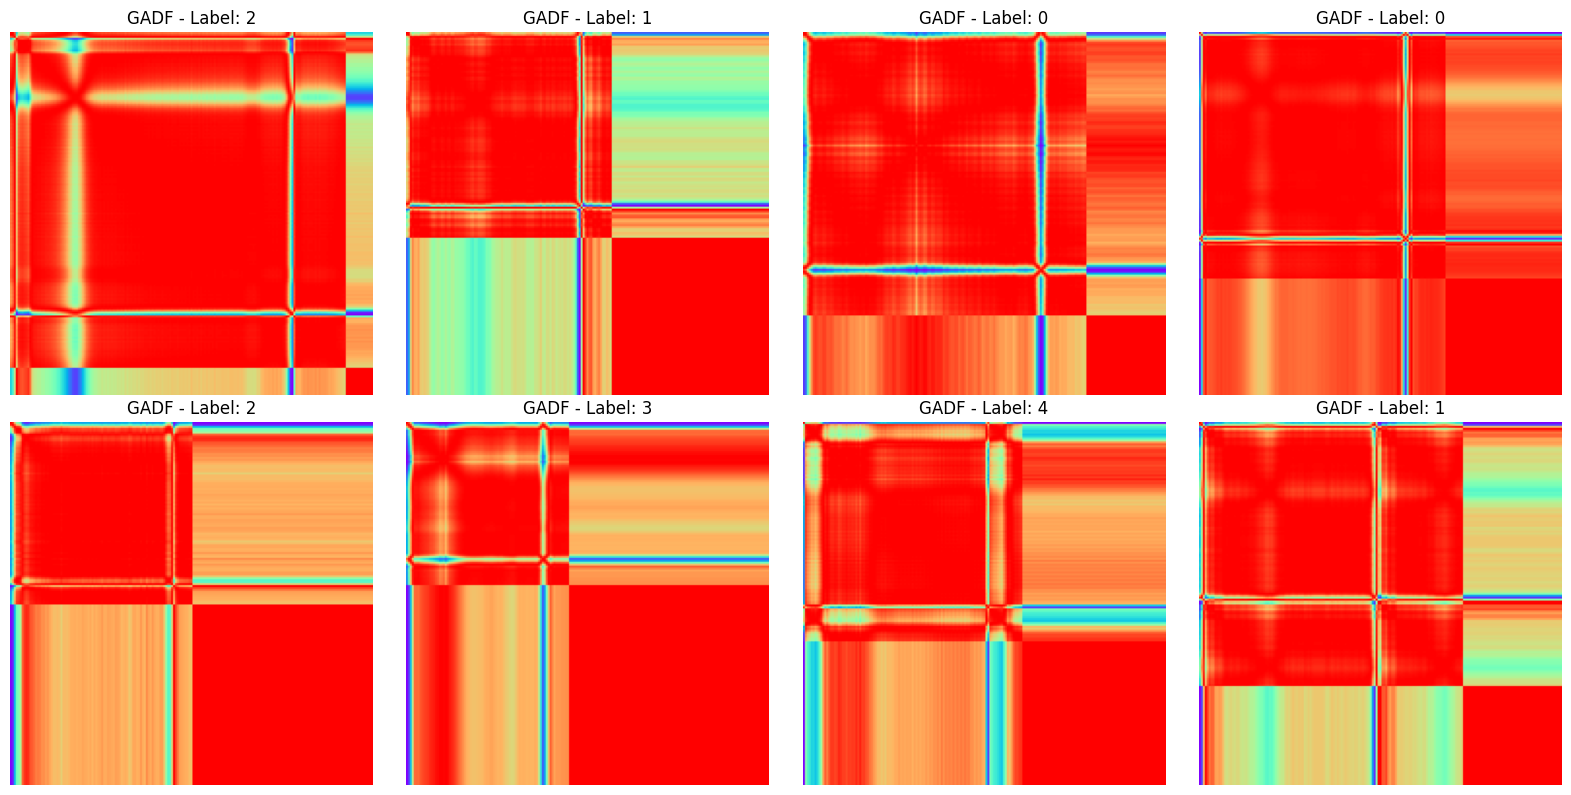

In [5]:
train_dataset_gadf = ECGDataset(signals=X_train,labels=y_train,gaf_mode='gadf')
plot_gaf_samples(dataset=train_dataset_gadf,num_samples=8,cols=4,gaf_type='GADF')

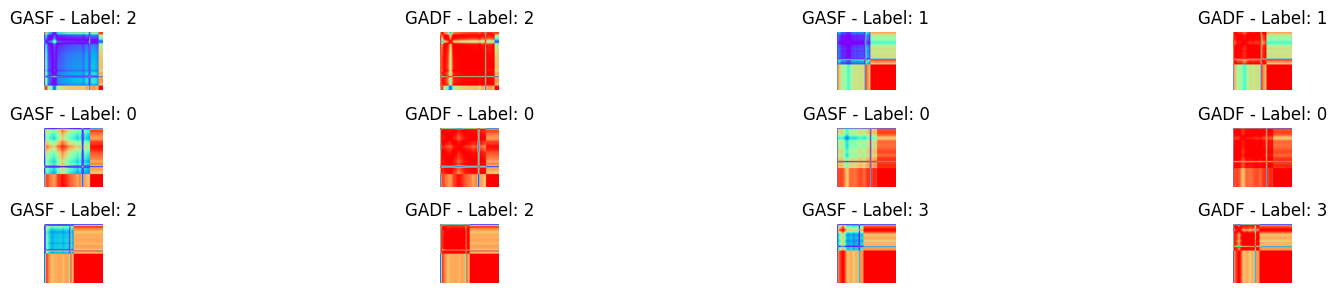

In [6]:
train_dataset_both = ECGDataset(signals=X_train,labels=y_train)
plot_gaf_both(dataset=train_dataset_both,num_samples=6,cols=4,gaf_type='GASF + GADF')

## Model 1 - CNN - GASF

In [7]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gasf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gasf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gasf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_1 = CNN()
train_model(model=model_1,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_1,
            model_path=model_path_1,
            patience=2)

Epoch 1/20 | Train Loss: 0.9077 | Train Acc: 0.6599 | Val Loss: 0.6446 | Val Acc: 0.7707 | Patience: 0
Epoch 2/20 | Train Loss: 0.5656 | Train Acc: 0.7855 | Val Loss: 0.5351 | Val Acc: 0.7956 | Patience: 0
Epoch 3/20 | Train Loss: 0.4388 | Train Acc: 0.8463 | Val Loss: 0.4848 | Val Acc: 0.8222 | Patience: 0
Epoch 4/20 | Train Loss: 0.3566 | Train Acc: 0.8690 | Val Loss: 0.4498 | Val Acc: 0.8565 | Patience: 0
Epoch 5/20 | Train Loss: 0.2906 | Train Acc: 0.8947 | Val Loss: 0.4330 | Val Acc: 0.8596 | Patience: 0
Epoch 6/20 | Train Loss: 0.2362 | Train Acc: 0.9130 | Val Loss: 0.4557 | Val Acc: 0.8596 | Patience: 0
Epoch 7/20 | Train Loss: 0.2149 | Train Acc: 0.9189 | Val Loss: 0.5097 | Val Acc: 0.8721 | Patience: 1
Epoch 8/20 | Train Loss: 0.1514 | Train Acc: 0.9446 | Val Loss: 0.4788 | Val Acc: 0.8612 | Patience: 0
Epoch 9/20 | Train Loss: 0.1025 | Train Acc: 0.9622 | Val Loss: 0.5328 | Val Acc: 0.8596 | Patience: 1
Early stopping triggered!


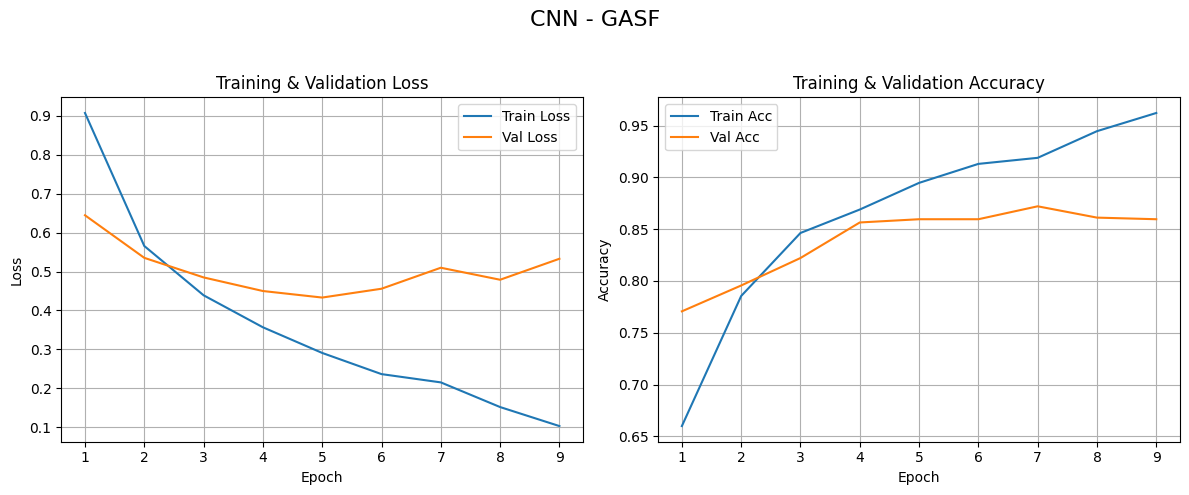

Accuracy: 0.8704
Classification Report:
               precision    recall  f1-score   support

           N       0.72      0.91      0.81       162
           S       0.88      0.80      0.84       162
           V       0.90      0.86      0.88       162
           F       0.94      0.81      0.87       162
           Q       0.96      0.97      0.97       162

    accuracy                           0.87       810
   macro avg       0.88      0.87      0.87       810
weighted avg       0.88      0.87      0.87       810



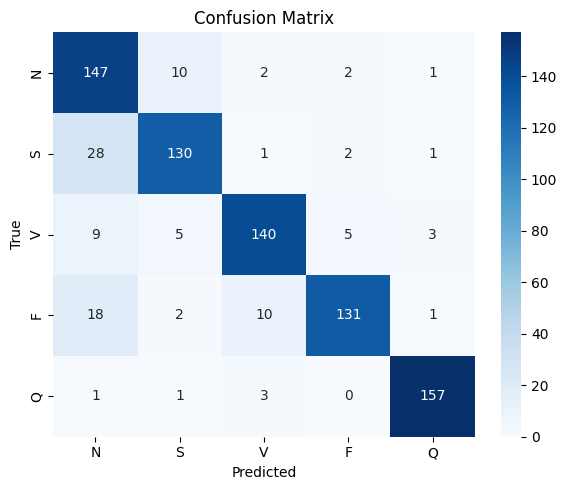

In [8]:
plot_classifier_curves(
    log_path=log_path_1,
    suptitle='CNN - GASF'
)

evaluate_classifier(
    model=model_1,
    dataloader=test_loader_1,
    class_names=class_names,
    device=device
)

## Model 2: CNN - GADF

In [9]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='gadf')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='gadf')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='gadf')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_2 = CNN()
train_model(model=model_2,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_2,
            model_path=model_path_2,
            patience=2)

Epoch 1/20 | Train Loss: 0.9375 | Train Acc: 0.6494 | Val Loss: 0.6457 | Val Acc: 0.7691 | Patience: 0
Epoch 2/20 | Train Loss: 0.5500 | Train Acc: 0.8097 | Val Loss: 0.5383 | Val Acc: 0.8034 | Patience: 0
Epoch 3/20 | Train Loss: 0.4244 | Train Acc: 0.8553 | Val Loss: 0.4682 | Val Acc: 0.8175 | Patience: 0
Epoch 4/20 | Train Loss: 0.3722 | Train Acc: 0.8612 | Val Loss: 0.4246 | Val Acc: 0.8424 | Patience: 0
Epoch 5/20 | Train Loss: 0.2927 | Train Acc: 0.8978 | Val Loss: 0.4309 | Val Acc: 0.8284 | Patience: 0
Epoch 6/20 | Train Loss: 0.2779 | Train Acc: 0.8994 | Val Loss: 0.4598 | Val Acc: 0.8393 | Patience: 1
Early stopping triggered!


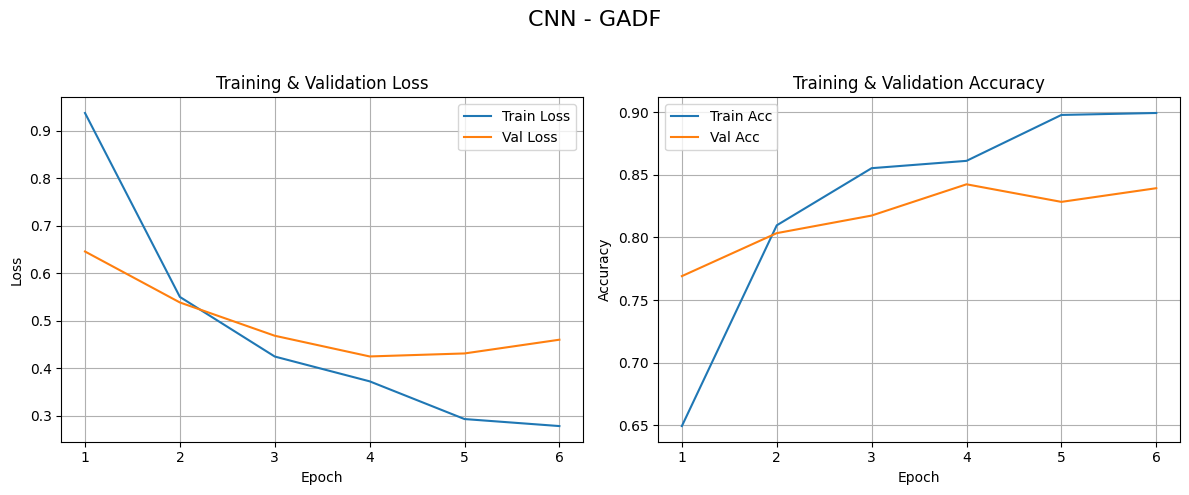

Accuracy: 0.8519
Classification Report:
               precision    recall  f1-score   support

           N       0.65      0.96      0.77       162
           S       0.95      0.69      0.80       162
           V       0.93      0.77      0.84       162
           F       0.93      0.88      0.91       162
           Q       0.95      0.96      0.95       162

    accuracy                           0.85       810
   macro avg       0.88      0.85      0.85       810
weighted avg       0.88      0.85      0.85       810



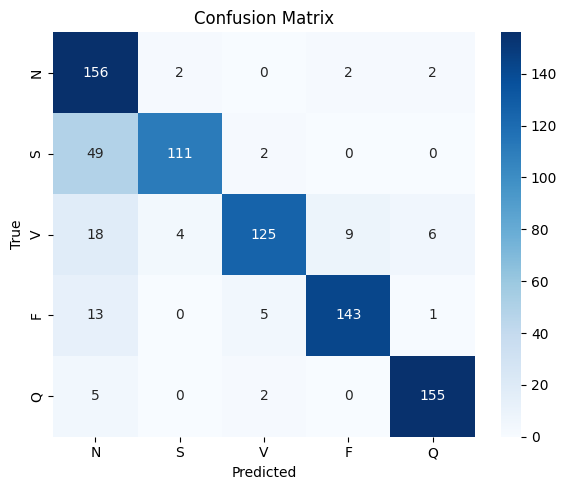

In [10]:
plot_classifier_curves(log_path=log_path_2,suptitle='CNN - GADF')

evaluate_classifier(
    model=model_2,
    dataloader=test_loader_2,
    class_names=class_names,
    device=device
)

## Model 3: CNN - both

In [11]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='both')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_3 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_3 = CNN(in_channels=2)
train_model(model=model_3,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_3,
            model_path=model_path_3,
            patience=2)

Epoch 1/20 | Train Loss: 0.9037 | Train Acc: 0.6517 | Val Loss: 0.6507 | Val Acc: 0.7800 | Patience: 0
Epoch 2/20 | Train Loss: 0.5616 | Train Acc: 0.8003 | Val Loss: 0.5661 | Val Acc: 0.7972 | Patience: 0
Epoch 3/20 | Train Loss: 0.4549 | Train Acc: 0.8378 | Val Loss: 0.4666 | Val Acc: 0.8315 | Patience: 0
Epoch 4/20 | Train Loss: 0.3784 | Train Acc: 0.8674 | Val Loss: 0.4495 | Val Acc: 0.8331 | Patience: 0
Epoch 5/20 | Train Loss: 0.3292 | Train Acc: 0.8729 | Val Loss: 0.4462 | Val Acc: 0.8378 | Patience: 0
Epoch 6/20 | Train Loss: 0.2743 | Train Acc: 0.8974 | Val Loss: 0.4048 | Val Acc: 0.8643 | Patience: 0
Epoch 7/20 | Train Loss: 0.2180 | Train Acc: 0.9220 | Val Loss: 0.4751 | Val Acc: 0.8580 | Patience: 0
Epoch 8/20 | Train Loss: 0.1852 | Train Acc: 0.9278 | Val Loss: 0.4634 | Val Acc: 0.8612 | Patience: 1
Early stopping triggered!


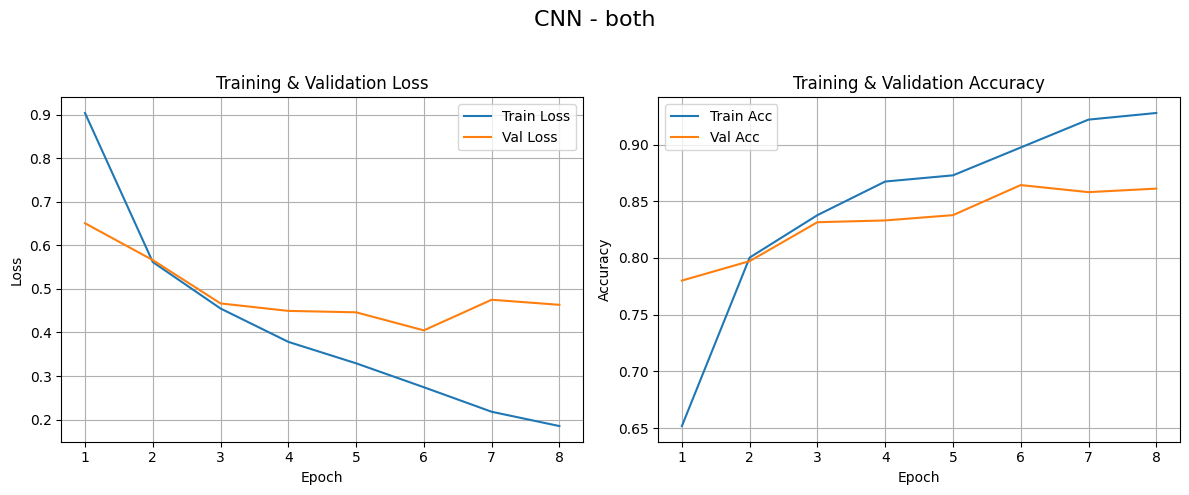

Accuracy: 0.8802
Classification Report:
               precision    recall  f1-score   support

           N       0.75      0.89      0.82       162
           S       0.93      0.78      0.85       162
           V       0.90      0.86      0.88       162
           F       0.89      0.92      0.91       162
           Q       0.96      0.95      0.95       162

    accuracy                           0.88       810
   macro avg       0.89      0.88      0.88       810
weighted avg       0.89      0.88      0.88       810



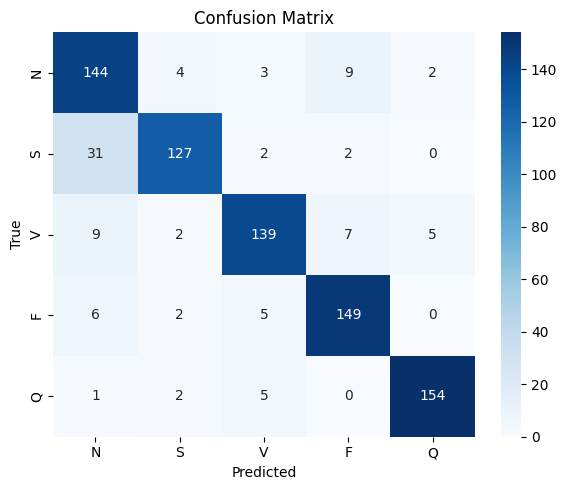

In [12]:
plot_classifier_curves(
    log_path=log_path_3,
    suptitle='CNN - both'
)

evaluate_classifier(
    model=model_3,
    dataloader=test_loader_3,
    class_names=class_names,
    device=device
)

## Model 4: ResNet - both

In [13]:
train_dataset = ECGDataset(signals=X_train,
                           labels=y_train,
                           gaf_mode='both')
val_dataset = ECGDataset(signals=X_val,
                         labels=y_val,
                         gaf_mode='both')
test_dataset = ECGDataset(signals=X_test,
                          labels=y_test,
                          gaf_mode='both')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE)
test_loader_4 = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE)


model_4 = build_resnet(in_channels=2)
train_model(model=model_4,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            num_epochs=20,
            log_path=log_path_4,
            model_path=model_path_4,
            patience=2)

c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\algorithms\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 | Train Loss: 0.6806 | Train Acc: 0.7601 | Val Loss: 0.7360 | Val Acc: 0.7722 | Patience: 0
Epoch 2/20 | Train Loss: 0.4739 | Train Acc: 0.8264 | Val Loss: 0.5703 | Val Acc: 0.7863 | Patience: 0
Epoch 3/20 | Train Loss: 0.4421 | Train Acc: 0.8569 | Val Loss: 0.5265 | Val Acc: 0.8456 | Patience: 0
Epoch 4/20 | Train Loss: 0.3930 | Train Acc: 0.8662 | Val Loss: 0.4471 | Val Acc: 0.8518 | Patience: 0
Epoch 5/20 | Train Loss: 0.3567 | Train Acc: 0.8791 | Val Loss: 0.4047 | Val Acc: 0.8643 | Patience: 0
Epoch 6/20 | Train Loss: 0.3092 | Train Acc: 0.8986 | Val Loss: 0.3506 | Val Acc: 0.8799 | Patience: 0
Epoch 7/20 | Train Loss: 0.2538 | Train Acc: 0.9158 | Val Loss: 0.3260 | Val Acc: 0.8877 | Patience: 0
Epoch 8/20 | Train Loss: 0.2820 | Train Acc: 0.9052 | Val Loss: 0.3583 | Val Acc: 0.8643 | Patience: 0
Epoch 9/20 | Train Loss: 0.2118 | Train Acc: 0.9259 | Val Loss: 0.3268 | Val Acc: 0.8846 | Patience: 1
Early stopping triggered!


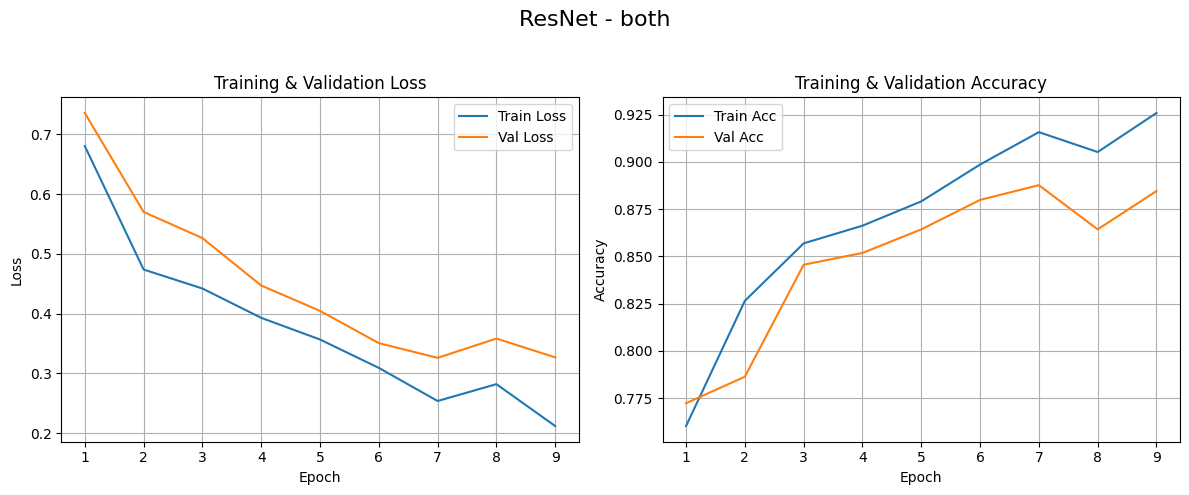

Accuracy: 0.9025
Classification Report:
               precision    recall  f1-score   support

           N       0.78      0.98      0.87       162
           S       0.95      0.77      0.85       162
           V       0.90      0.91      0.91       162
           F       0.95      0.89      0.92       162
           Q       0.99      0.97      0.98       162

    accuracy                           0.90       810
   macro avg       0.91      0.90      0.90       810
weighted avg       0.91      0.90      0.90       810



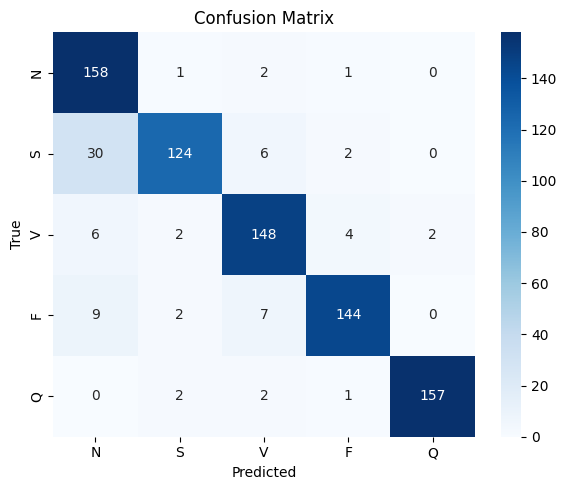

In [14]:
plot_classifier_curves(
    log_path=log_path_4,
    suptitle='ResNet - both'
)

evaluate_classifier(
    model=model_4,
    dataloader=test_loader_4,
    class_names=class_names,
    device=device
)